# Exploratory Data Analysis


In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from pathlib import Path

import sys


In [3]:
# Path to your data
DATA_DIR = Path("../data/map")
gdf_path = DATA_DIR / "brazil_municipalities.gpkg"

# Load the GeoPackage
gdf = gpd.read_file(gdf_path)

print(f"Loaded {gdf.shape[0]} municipalities with {gdf.shape[1]} columns")
gdf.head()


Loaded 5572 municipalities with 14 columns


,CD_MUN,NM_MUN,CD_RGI,NM_RGI,CD_RGINT,NM_RGINT,CD_UF,NM_UF,CD_REGIAO,NM_REGIAO,CD_CONCURB,NM_CONCURB,AREA_KM2,geometry
0,1100015,Alta Floresta D'Oeste,110005,Cacoal,1102,Ji-Paraná,11,Rondônia,1,Norte,None,None,7067.127,"MULTIPOLYGON (((-61.93075 -11.97349, -61.93234..."
1,1100023,Ariquemes,110002,Ariquemes,1101,Porto Velho,11,Rondônia,1,Norte,None,None,4426.143,"MULTIPOLYGON (((-63.17933 -10.13924, -63.17746..."
2,1100031,Cabixi,110006,Vilhena,1102,Ji-Paraná,11,Rondônia,1,Norte,None,None,1314.352,"MULTIPOLYGON (((-60.56035 -13.32206, -60.52518..."
3,1100049,Cacoal,110005,Cacoal,1102,Ji-Paraná,11,Rondônia,1,Norte,None,None,3793.000,"MULTIPOLYGON (((-61.00075 -11.25298, -61.0008 ..."
4,1100056,Cerejeiras,110006,Vilhena,1102,Ji-Paraná,11,Rondônia,1,Norte,None,None,2783.297,"MULTIPOLYGON (((-60.82068 -13.11944, -60.81773..."


(-76.24759050499995,
 -26.59049939499993,
 -35.702328954999984,
 7.222992055000077)

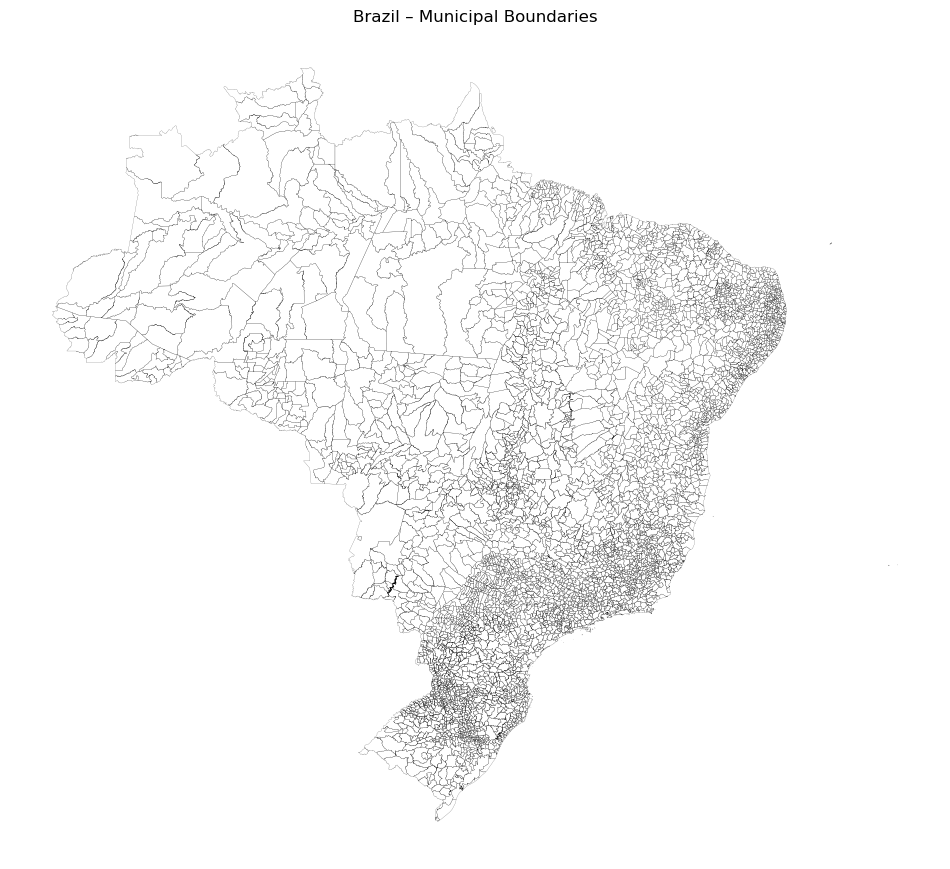

In [ ]:
# Basoc Map
fig, ax = plt.subplots(figsize=(12, 12))

gdf.plot(
    ax=ax,
    linewidth=0.1,
    edgecolor="black",
    facecolor="none"
)

ax.set_title("Brazil – Municipal Boundaries")
ax.axis("off")


C:\Users\armin\OneDrive\Desktop\Projects\dengue\src\spatial\spatial_graph.py:175: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  coords = np.column_stack([gdf.geometry.centroid.x.values,
C:\Users\armin\OneDrive\Desktop\Projects\dengue\src\spatial\spatial_graph.py:176: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.geometry.centroid.y.values])


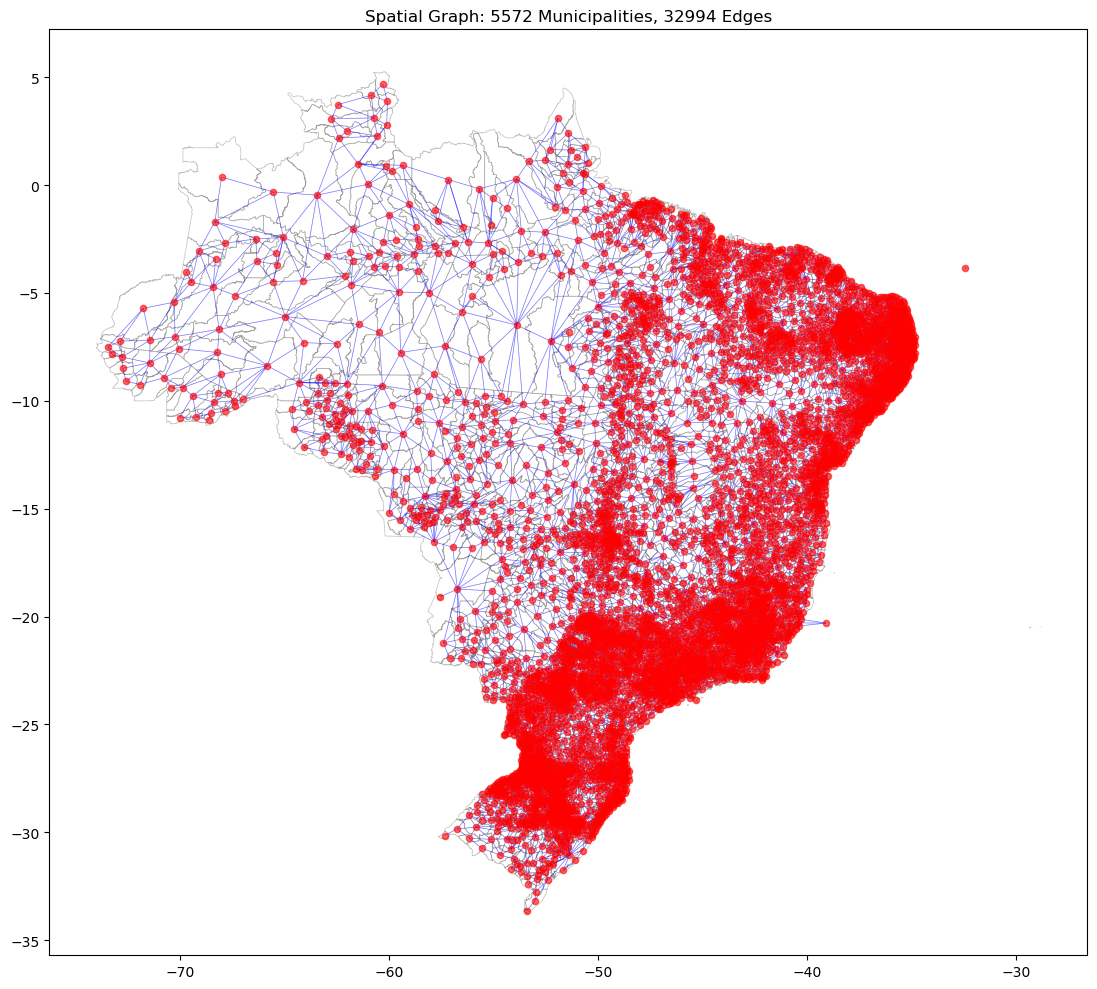

Nodes: 5572
Edges: 32994

Sample nodes:
   node_id municipality_code      municipality_name             x  \
0        0           1100015  Alta Floresta D'Oeste  4.100633e+06   
1        1           1100023              Ariquemes  4.017880e+06   
2        2           1100031                 Cabixi  4.281167e+06   
3        3           1100049                 Cacoal  4.200412e+06   
4        4           1100056             Cerejeiras  4.213033e+06   

              y  
0  8.606922e+06  
1  8.886193e+06  
2  8.500043e+06  
3  8.740187e+06  
4  8.528364e+06  


In [5]:
# Add the src/spatial directory to Python path
sys.path.insert(0, str(Path("../src/spatial").resolve()))

#  import
from spatial_graph import SpatialGraphBuilder

sg = SpatialGraphBuilder(spatial_dir=Path("../data/spatial"))
edge_index, edge_weights, nodes = sg.construct_spatial_graph(
    gdf=gdf,
    method="adjacency",
    save_name="rio_adjacency"
)

# Visualize
sg.visualize_spatial_graph(
    gdf, 
    edge_index,
    output_path=Path("../data/spatial/graph_viz.png")
)

# Check results
print(f"Nodes: {len(nodes)}")
print(f"Edges: {edge_index.shape[1]}")
print(f"\nSample nodes:")
print(nodes.head())

C:\Users\armin\AppData\Local\Temp\ipykernel_43388\44706433.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_centroids["geometry"] = gdf_centroids.geometry.centroid


(-76.24759050499995,
 -26.59049939499993,
 -35.702328954999984,
 7.222992055000077)

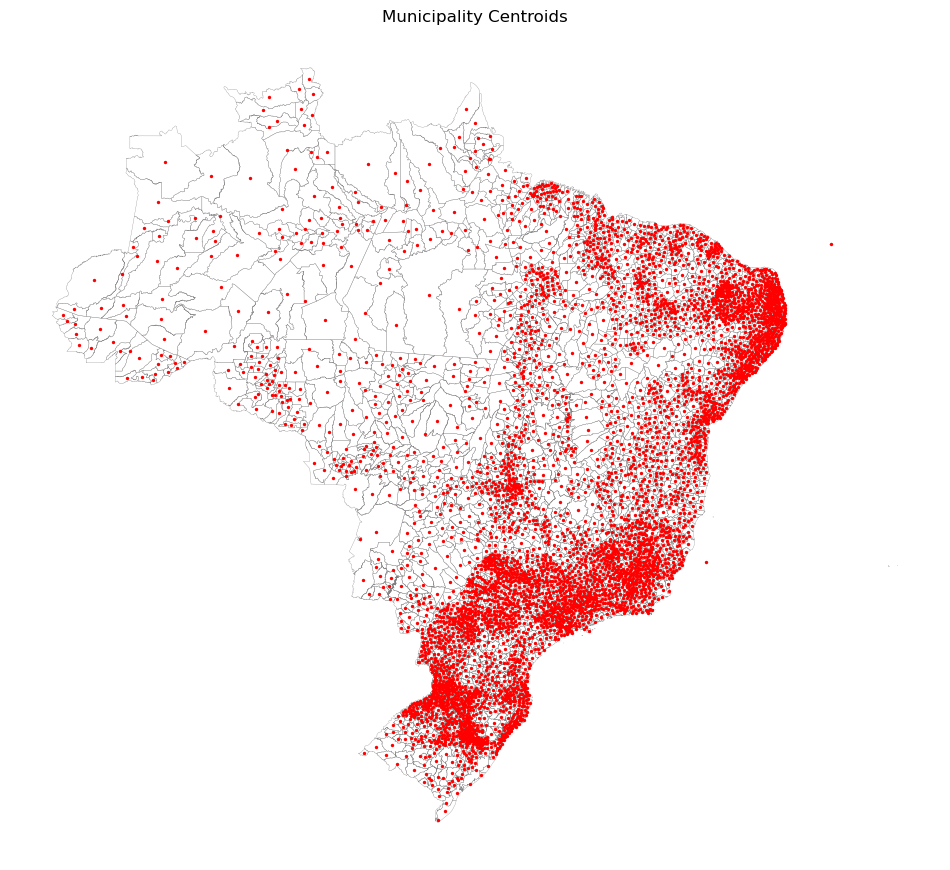

In [6]:
# Map centroids
gdf_centroids = gdf.copy()
gdf_centroids["geometry"] = gdf_centroids.geometry.centroid

fig, ax = plt.subplots(figsize=(12, 12))

gdf.plot(ax=ax, facecolor="none", edgecolor="gray", linewidth=0.2)
gdf_centroids.plot(ax=ax, color="red", markersize=2)

ax.set_title("Municipality Centroids")
ax.axis("off")


In [7]:

# Coordinates of nodes
coords = nodes[["x", "y"]].values

# Sample edges for visualization
E = edge_index.shape[1]
sample_size = min(3000, E)  # plot at most 3000 edges
sample_idx = np.random.choice(E, size=sample_size, replace=False)

# Build line segments for the sampled edges
lines = [
    [coords[edge_index[0, i]], coords[edge_index[1, i]]]
    for i in sample_idx
]

# Plot municipality boundaries as the base map
gdf.boundary.plot(ax=ax, edgecolor="lightgray", linewidth=0.3)

# Plot edges
lc = LineCollection(lines, colors="blue", linewidths=0.3, alpha=0.2)
ax.add_collection(lc)

# Plot nodes
ax.scatter(coords[:, 0], coords[:, 1], s=5, c="red", alpha=0.4, zorder=5)

# Final touches
ax.set_title("Brazil Municipality Spatial Graph (Adjacency – Sampled)", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_aspect("equal")
ax.axis("off")  # optional to remove axes

plt.tight_layout()
plt.show()


<Figure size 640x480 with 0 Axes>

Text(0, 0.5, 'Count')

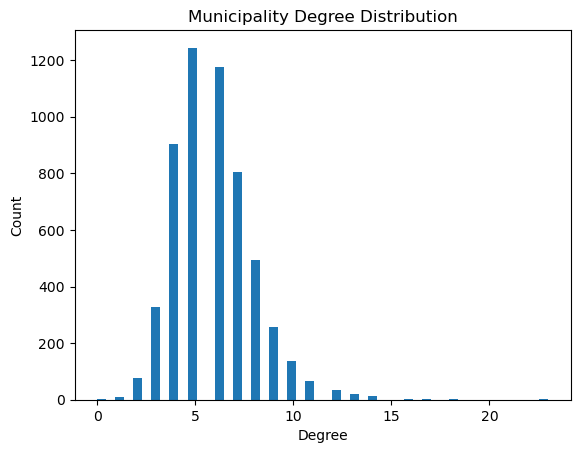

In [8]:
# Degree diagnostrics
degrees = np.bincount(edge_index[0])

pd.Series(degrees).describe()

plt.hist(degrees, bins=50)
plt.title("Municipality Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Count")


(-53.55754881499996,
 -43.713927884999976,
 -25.63691699999996,
 -19.50073859999994)

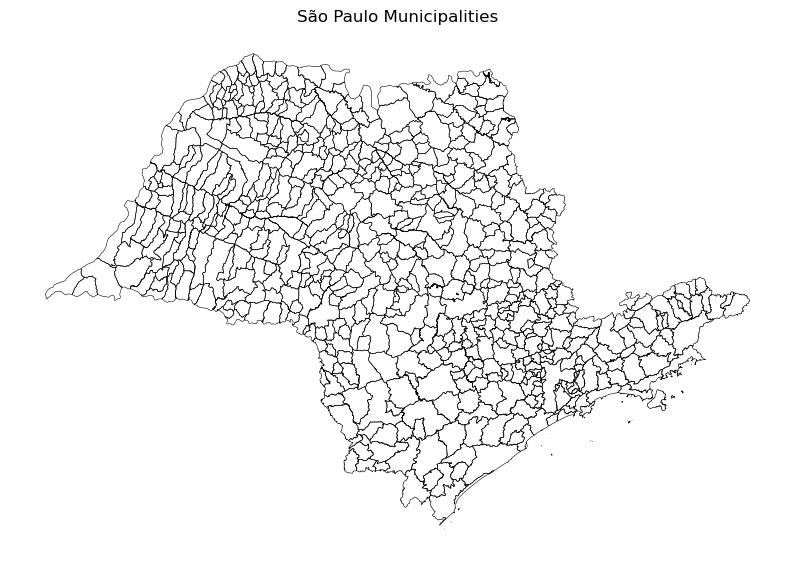

In [9]:
# Zoom into São Paulo
sp_state = gdf[gdf["NM_UF"] == "São Paulo"]

fig, ax = plt.subplots(figsize=(10, 10))
sp_state.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=0.4)
ax.set_title("São Paulo Municipalities")
ax.axis("off")


In [10]:
# Load Infodengue dataset

INFODENGUE_PATH = Path("../data/infodengue/raw/infodengue_combined.csv")

df_dengue = pd.read_csv(INFODENGUE_PATH)

# Ensure datetime
df_dengue["data_iniSE"] = pd.to_datetime(df_dengue["data_iniSE"])

# Extract year and epidemiological week
df_dengue["year"] = df_dengue["data_iniSE"].dt.year
df_dengue["epiweek"] = df_dengue["data_iniSE"].dt.isocalendar().week.astype(int)

df_dengue.head()

,data_iniSE,SE,casos_est,casos_est_min,casos_est_max,casos,p_rt1,p_inc100k,Localidade_id,nivel,...,tempmax,casprov,casprov_est,casprov_est_min,casprov_est_max,casconf,notif_accum_year,geocode,year,epiweek
0,2021-12-26,202152,0.0,0,0.0,0,0.000000e+00,0.000000,0,1,...,24.857143,0.0,NaN,NaN,NaN,NaN,148,5200050,2021,51
1,2021-12-19,202151,1.0,1,1.0,1,9.809487e-12,11.163206,0,2,...,25.857143,1.0,NaN,NaN,NaN,NaN,148,5200050,2021,50
2,2021-12-12,202150,37.0,37,37.0,37,8.108776e-01,413.038640,0,4,...,26.000000,37.0,NaN,NaN,NaN,NaN,148,5200050,2021,49
3,2021-12-05,202149,46.0,46,46.0,46,9.999637e-01,513.507500,0,4,...,27.428571,45.0,NaN,NaN,NaN,NaN,148,5200050,2021,48
4,2021-11-28,202148,36.0,36,36.0,36,9.999994e-01,401.875430,0,2,...,26.714286,31.0,NaN,NaN,NaN,NaN,148,5200050,2021,47


In [11]:
#  Deduplicate the map 
gdf_unique = gdf.drop_duplicates(subset="CD_MUN", keep="first").copy()
gdf_unique = gpd.GeoDataFrame(
    gdf_unique,
    geometry="geometry",
    crs=gdf.crs
)

# Convert CD_MUN to string with padding
gdf_unique["CD_MUN"] = gdf_unique["CD_MUN"].astype(str).str.zfill(7)

#  Build metadata lookup
map_meta = gdf_unique[["CD_MUN", "NM_MUN", "NM_UF", "AREA_KM2"]].copy()
lookup = map_meta.set_index("CD_MUN").to_dict("index")

# Convert geocode to string with zero-padding BEFORE mapping
df_dengue["geocode_str"] = df_dengue["geocode"].astype(str).str.zfill(7)

# Attach metadata to dengue using the string version
df_dengue["NM_MUN"] = df_dengue["geocode_str"].map(lambda x: lookup.get(x, {}).get("NM_MUN"))
df_dengue["NM_UF"]  = df_dengue["geocode_str"].map(lambda x: lookup.get(x, {}).get("NM_UF"))
df_dengue["AREA_KM2"] = df_dengue["geocode_str"].map(lambda x: lookup.get(x, {}).get("AREA_KM2"))

# Attach geometry using the string version
geom_lookup = gdf_unique.set_index("CD_MUN")["geometry"].to_dict()
df_dengue["geometry"] = df_dengue["geocode_str"].map(geom_lookup)

# Convert to GeoDataFrame using the CRS from gdf_unique
gdf_dengue = gpd.GeoDataFrame(df_dengue, geometry="geometry", crs=gdf_unique.crs)

# Check if it worked
print(f"Total rows: {len(gdf_dengue)}")
print(f"Missing geometries: {gdf_dengue.geometry.isna().sum()}")
print(f"Percentage with geometry: {(~gdf_dengue.geometry.isna()).mean() * 100:.1f}%")

gdf_dengue.head()

Total rows: 1157301
Missing geometries: 0
Percentage with geometry: 100.0%


,data_iniSE,SE,casos_est,casos_est_min,casos_est_max,casos,p_rt1,p_inc100k,Localidade_id,nivel,...,casconf,notif_accum_year,geocode,year,epiweek,geocode_str,NM_MUN,NM_UF,AREA_KM2,geometry
0,2021-12-26,202152,0.0,0,0.0,0,0.000000e+00,0.000000,0,1,...,NaN,148,5200050,2021,51,5200050,Abadia de Goiás,Goiás,143.357,"MULTIPOLYGON (((-49.38849 -16.82747, -49.38854..."
1,2021-12-19,202151,1.0,1,1.0,1,9.809487e-12,11.163206,0,2,...,NaN,148,5200050,2021,50,5200050,Abadia de Goiás,Goiás,143.357,"MULTIPOLYGON (((-49.38849 -16.82747, -49.38854..."
2,2021-12-12,202150,37.0,37,37.0,37,8.108776e-01,413.038640,0,4,...,NaN,148,5200050,2021,49,5200050,Abadia de Goiás,Goiás,143.357,"MULTIPOLYGON (((-49.38849 -16.82747, -49.38854..."
3,2021-12-05,202149,46.0,46,46.0,46,9.999637e-01,513.507500,0,4,...,NaN,148,5200050,2021,48,5200050,Abadia de Goiás,Goiás,143.357,"MULTIPOLYGON (((-49.38849 -16.82747, -49.38854..."
4,2021-11-28,202148,36.0,36,36.0,36,9.999994e-01,401.875430,0,2,...,NaN,148,5200050,2021,47,5200050,Abadia de Goiás,Goiás,143.357,"MULTIPOLYGON (((-49.38849 -16.82747, -49.38854..."


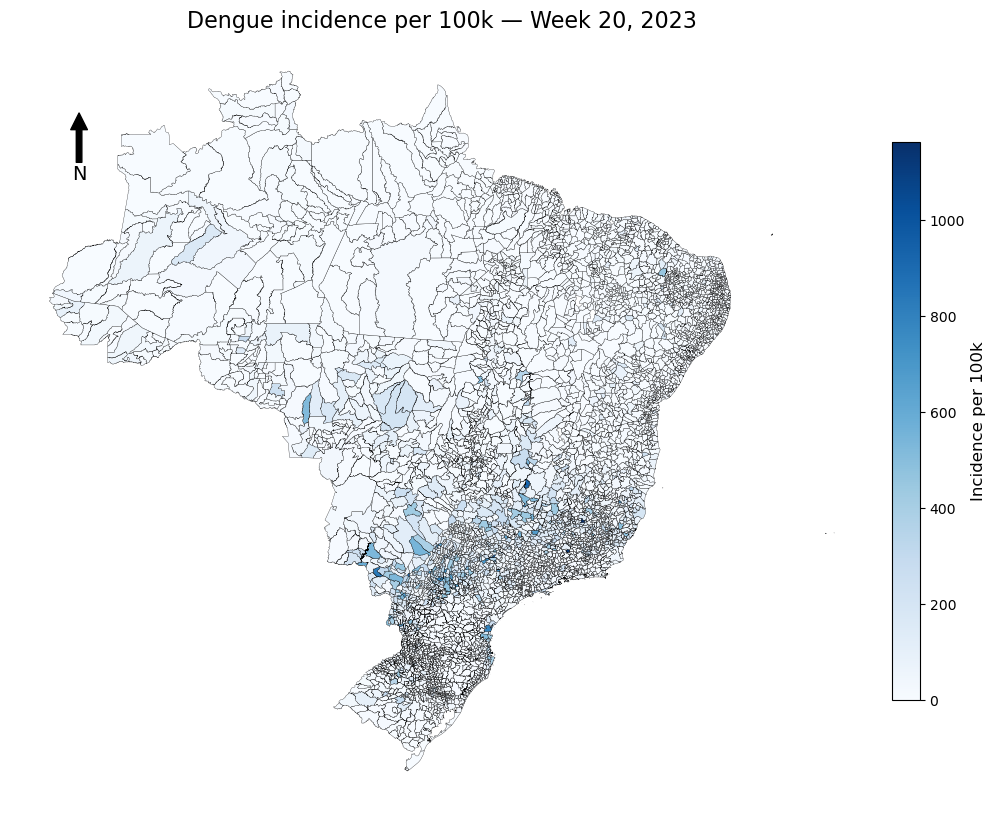

In [12]:
# North Arrow helper
def add_north_arrow(ax, size=0.08, loc=(0.08, 0.9)):
    """
    Add a north arrow to a matplotlib Axes.
    loc is in axes fraction coordinates.
    """
    x, y = loc
    ax.annotate(
        "N",
        xy=(x, y),
        xytext=(x, y - size),
        arrowprops=dict(facecolor="black", width=4, headwidth=12),
        ha="center",
        va="center",
        fontsize=14,
        xycoords=ax.transAxes,
    )

# Choose a timepoint
year = 2023
epiweek = 20

gdf_week = gdf_dengue[
    (gdf_dengue["year"] == year) &
    (gdf_dengue["epiweek"] == epiweek)
].copy()

# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Choropleth (Blues)
gdf_week.plot(
    column="p_inc100k",
    cmap="Blues",
    linewidth=0.2,
    edgecolor="black",
    ax=ax
)

# Gradient colorbar (Blues)
sm = mpl.cm.ScalarMappable(
    cmap="Blues",
    norm=mpl.colors.Normalize(
        vmin=gdf_week["p_inc100k"].min(),
        vmax=gdf_week["p_inc100k"].max()
    )
)
sm._A = []
cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
cbar.set_label("Incidence per 100k", fontsize=12)

# Add north arrow
add_north_arrow(ax)

# Labels
ax.set_title(f"Dengue incidence per 100k — Week {epiweek}, {year}", fontsize=16)
ax.axis("off")

plt.show()

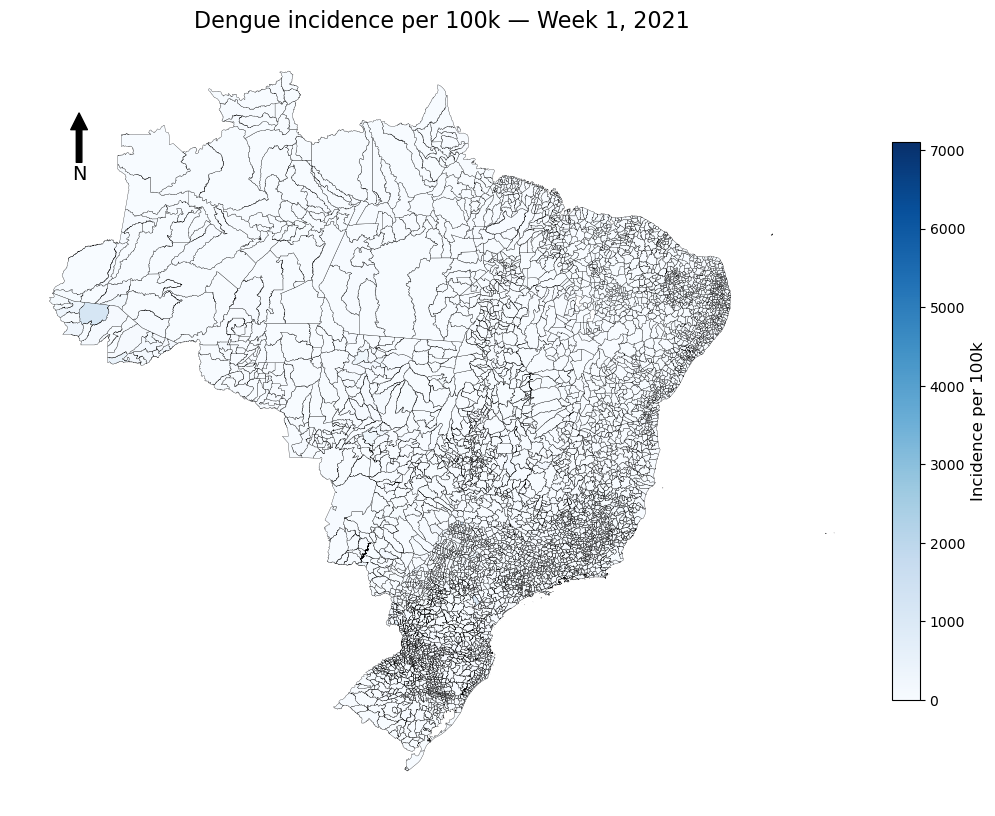

In [13]:
import matplotlib.animation as animation
import os

# Create results folder if it doesn't exist
os.makedirs('results', exist_ok=True)

# North Arrow helper (same as yours)
def add_north_arrow(ax, size=0.08, loc=(0.08, 0.9)):
    """
    Add a north arrow to a matplotlib Axes.
    loc is in axes fraction coordinates.
    """
    x, y = loc
    ax.annotate(
        "N",
        xy=(x, y),
        xytext=(x, y - size),
        arrowprops=dict(facecolor="black", width=4, headwidth=12),
        ha="center",
        va="center",
        fontsize=14,
        xycoords=ax.transAxes,
    )

# Get all unique year-epiweek combinations, sorted
time_periods = gdf_dengue[['year', 'epiweek']].drop_duplicates().sort_values(['year', 'epiweek'])

# Set up the figure
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Get global min/max for consistent color scale across all frames
vmin = gdf_dengue['p_inc100k'].min()
vmax = gdf_dengue['p_inc100k'].max()

# Create colorbar (will be fixed across all frames)
sm = mpl.cm.ScalarMappable(
    cmap="Blues",
    norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax)
)
sm._A = []
cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
cbar.set_label("Incidence per 100k", fontsize=12)

def update(frame):
    """Update function for animation"""
    ax.clear()
    
    # Get data for this time period
    year = time_periods.iloc[frame]['year']
    epiweek = time_periods.iloc[frame]['epiweek']
    
    gdf_week = gdf_dengue[
        (gdf_dengue["year"] == year) &
        (gdf_dengue["epiweek"] == epiweek)
    ].copy()
    
    # Plot choropleth
    gdf_week.plot(
        column="p_inc100k",
        cmap="Blues",
        linewidth=0.2,
        edgecolor="black",
        ax=ax,
        vmin=vmin,  # Fixed scale
        vmax=vmax
    )
    
    # Add north arrow
    add_north_arrow(ax)
    
    # Labels
    ax.set_title(f"Dengue incidence per 100k — Week {epiweek}, {year}", fontsize=16)
    ax.axis("off")
    
    return ax,

# Create animation
anim = animation.FuncAnimation(
    fig, 
    update, 
    frames=len(time_periods),
    interval=200,  # 200ms between frames
    blit=False,
    repeat=True
)

# Save as GIF
#print("Saving animation as GIF...")
#anim.save('../results/dengue_animation.gif', writer='pillow', fps=5, dpi=100)
#print("Animation saved to results/dengue_animation.gif")


# Graph Neural Network Model

Training a spatiotemporal GNN to predict dengue incidence.

In [ ]:
# GNN imports
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch_geometric.nn import GCNConv

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

c:\Users\armin\miniconda3\envs\dengue\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


In [ ]:
# Prepare data for GNN
# Convert gdf_dengue to regular DataFrame (drop geometry if present)
if 'geometry' in gdf_dengue.columns:
    df_dengue = gdf_dengue.drop(columns=['geometry'])
else:
    df_dengue = gdf_dengue.copy()

print(f"Data shape: {df_dengue.shape}")
print(f"Columns: {df_dengue.columns.tolist()}")
print(f"Time range: {df_dengue['year'].min()}-{df_dengue['year'].max()}")
print(f"Number of municipalities: {df_dengue['geocode'].nunique()}")

# Add CD_MUN column for compatibility with GNN code (use geocode_str for string version)
df_dengue['CD_MUN'] = df_dengue['geocode_str']

# Also add the regional columns if they don't exist (from gdf_unique)
if 'CD_UF' not in df_dengue.columns:
    # Create a lookup from gdf_unique
    region_cols = ['CD_UF', 'CD_RGI', 'CD_RGINT', 'CD_REGIAO', 'CD_CONCURB']
    region_lookup = gdf_unique[['CD_MUN'] + region_cols].drop_duplicates('CD_MUN')
    
    # Merge with df_dengue
    df_dengue = df_dengue.merge(
        region_lookup,
        left_on='geocode_str',
        right_on='CD_MUN',
        how='left',
        suffixes=('', '_from_gdf')
    )
    
    # Drop duplicate CD_MUN column if created
    if 'CD_MUN_from_gdf' in df_dengue.columns:
        df_dengue = df_dengue.drop(columns=['CD_MUN_from_gdf'])

print("\nAfter adding regional columns:")
print(f"Columns: {df_dengue.columns.tolist()}")

Data shape: (1157301, 37)
Columns: ['data_iniSE', 'SE', 'casos_est', 'casos_est_min', 'casos_est_max', 'casos', 'p_rt1', 'p_inc100k', 'Localidade_id', 'nivel', 'id', 'versao_modelo', 'tweet', 'Rt', 'pop', 'tempmin', 'umidmax', 'receptivo', 'transmissao', 'nivel_inc', 'umidmed', 'umidmin', 'tempmed', 'tempmax', 'casprov', 'casprov_est', 'casprov_est_min', 'casprov_est_max', 'casconf', 'notif_accum_year', 'geocode', 'year', 'epiweek', 'geocode_str', 'NM_MUN', 'NM_UF', 'AREA_KM2']
Time range: 2021-2024
Number of municipalities: 5570

After adding regional columns:
Columns: ['data_iniSE', 'SE', 'casos_est', 'casos_est_min', 'casos_est_max', 'casos', 'p_rt1', 'p_inc100k', 'Localidade_id', 'nivel', 'id', 'versao_modelo', 'tweet', 'Rt', 'pop', 'tempmin', 'umidmax', 'receptivo', 'transmissao', 'nivel_inc', 'umidmed', 'umidmin', 'tempmed', 'tempmax', 'casprov', 'casprov_est', 'casprov_est_min', 'casprov_est_max', 'casconf', 'notif_accum_year', 'geocode', 'year', 'epiweek', 'geocode_str', 'NM_MU

In [ ]:
print("Creating edge index based on K-nearest neighbors...")
from sklearn.neighbors import NearestNeighbors

# Get centroids of municipalities
mun_geoms = gdf_unique[['CD_MUN', 'geometry']].copy()
mun_geoms['centroid'] = mun_geoms.geometry.centroid
mun_geoms['x'] = mun_geoms.centroid.x
mun_geoms['y'] = mun_geoms.centroid.y

# Filter to municipalities in df_dengue
mun_ids = sorted(df_dengue['CD_MUN'].unique())
mun_geoms = mun_geoms[mun_geoms['CD_MUN'].isin(mun_ids)]
mun_to_idx = {m: i for i, m in enumerate(mun_ids)}

# Get coordinates
coords = mun_geoms[['x', 'y']].values

# Find K nearest neighbors
k = 8  # each municipality connected to 8 nearest neighbors
nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree').fit(coords)
distances, indices = nbrs.kneighbors(coords)

# Build edge index
edges = []
for i, neighbors in enumerate(indices):
    for j in neighbors[1:]:  # skip first (itself)
        edges.append([i, j])

edge_index = torch.tensor(edges, dtype=torch.long).t()
print(f"Created edge_index with {k}-NN: {edge_index.shape}")
print(f"Number of edges: {edge_index.shape[1]}")

# Save for future use
output_path = Path("../data/processed")
output_path.mkdir(parents=True, exist_ok=True)
np.save(output_path / "edge_index.npy", edge_index.numpy())
print(f"Saved edge_index to {output_path / 'edge_index.npy'}")

Creating edge index based on K-nearest neighbors...


C:\Users\armin\AppData\Local\Temp\ipykernel_43388\632155012.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  mun_geoms['centroid'] = mun_geoms.geometry.centroid
C:\Users\armin\AppData\Local\Temp\ipykernel_43388\632155012.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  mun_geoms['x'] = mun_geoms.centroid.x
C:\Users\armin\AppData\Local\Temp\ipykernel_43388\632155012.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  mun_geoms['y'] = mun_geoms.centroid.y


Created edge_index with 8-NN: torch.Size([2, 44560])
Number of edges: 44560
Saved edge_index to ..\data\processed\edge_index.npy


In [ ]:
# Dataset class (FIXED VERSION)
class DengueSpatioTemporalDataset(Dataset):
    """
    Builds sequences of T weeks to predict week T+1 incidence.
    """
    def __init__(self, df, edge_index, T=4, train=True, train_frac=0.8):
        self.T = T
        self.edge_index = edge_index
        
        # Sort by time
        df = df.sort_values(["year", "epiweek", "CD_MUN"]).copy()
        
        # Create time index
        df["time_id"] = df["year"].astype(int) * 100 + df["epiweek"].astype(int)
        time_ids = sorted(df["time_id"].unique())
        
        # Train/test split
        split_idx = int(len(time_ids) * train_frac)
        self.time_ids = time_ids[:split_idx] if train else time_ids[split_idx:]
        
        # Node ordering
        mun_ids = sorted(df["CD_MUN"].unique())
        self.mun_to_idx = {m: i for i, m in enumerate(mun_ids)}
        self.num_nodes = len(mun_ids)
        
        # Static features
        static_df = df.drop_duplicates("CD_MUN").sort_values("CD_MUN")
        
        region_cols = ["CD_UF", "CD_RGI", "CD_RGINT", "CD_REGIAO", "CD_CONCURB"]
        
        # Encode categorical features
        static_feats = [static_df["AREA_KM2"].values[:, None].astype(np.float32)]
        
        for col in region_cols:
            # Handle None/NaN values and convert everything to string first
            vals = static_df[col].fillna(-1).astype(str)
            uniques = sorted(vals.unique())
            mapping = {v: i for i, v in enumerate(uniques)}
            encoded = vals.map(mapping).values[:, None].astype(np.int64)
            static_feats.append(encoded)
        
        self.static_X = np.concatenate(static_feats, axis=1)
        
        # Dynamic feature: p_inc100k
        self.time_to_dynamic = {}
        for t in time_ids:
            df_t = df[df["time_id"] == t]
            x = np.zeros(self.num_nodes, dtype=np.float32)
            for _, row in df_t.iterrows():
                idx = self.mun_to_idx[row["CD_MUN"]]
                x[idx] = row["p_inc100k"]
            self.time_to_dynamic[t] = x
        
        # Build samples
        self.samples = []
        for i in range(len(self.time_ids) - T):
            hist = self.time_ids[i : i + T]
            target = self.time_ids[i + T]
            self.samples.append((hist, target))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        hist_times, target_time = self.samples[idx]
        
        # Dynamic sequence: [T, N, 1]
        dyn_seq = []
        for t in hist_times:
            x = self.time_to_dynamic[t]
            dyn_seq.append(x[:, None])
        dyn_seq = np.stack(dyn_seq, axis=0)
        
        # Target: [N]
        y = self.time_to_dynamic[target_time]
        
        return (
            torch.from_numpy(dyn_seq).float(),
            torch.from_numpy(self.static_X).float(),
            torch.from_numpy(y).float(),
            self.edge_index.long(),
        )

print("Dataset class defined!")

Dataset class defined!


In [ ]:
# GNN Model
class SpatioTemporalGNN(nn.Module):
    """
    GCN applied to dynamic + static features, then GRU over time.
    """
    def __init__(self, dyn_in=1, static_in=6, gcn_hidden=32, gcn_layers=2, rnn_hidden=64):
        super().__init__()
        
        self.input_dim = dyn_in + static_in
        
        # GCN stack
        self.gcn_layers = nn.ModuleList()
        self.gcn_layers.append(GCNConv(self.input_dim, gcn_hidden))
        for _ in range(gcn_layers - 1):
            self.gcn_layers.append(GCNConv(gcn_hidden, gcn_hidden))
        
        # GRU over time
        self.rnn = nn.GRU(
            input_size=gcn_hidden,
            hidden_size=rnn_hidden,
            batch_first=True,
        )
        
        # Final prediction
        self.mlp = nn.Sequential(
            nn.Linear(rnn_hidden, rnn_hidden),
            nn.ReLU(),
            nn.Linear(rnn_hidden, 1),
        )
    
    def forward(self, dyn_seq, static, edge_index):
        T, N, _ = dyn_seq.shape
        gcn_outputs = []
        
        for t in range(T):
            x_t = dyn_seq[t]
            x = torch.cat([x_t, static], dim=1)
            
            h = x
            for gcn in self.gcn_layers:
                h = torch.relu(gcn(h, edge_index))
            gcn_outputs.append(h)
        
        # [T, N, H] → [N, T, H]
        H = torch.stack(gcn_outputs, dim=0).permute(1, 0, 2)
        
        out, _ = self.rnn(H)
        last = out[:, -1, :]
        
        return self.mlp(last).squeeze(-1)

print("Model class defined!")

Model class defined!


In [ ]:
# Create datasets
print("Creating datasets...")
train_ds = DengueSpatioTemporalDataset(df_dengue, edge_index, T=4, train=True, train_frac=0.8)
test_ds = DengueSpatioTemporalDataset(df_dengue, edge_index, T=4, train=False, train_frac=0.8)

print(f"Train samples: {len(train_ds)}")
print(f"Test samples: {len(test_ds)}")
print(f"Number of nodes: {train_ds.num_nodes}")

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)


Creating datasets...
Train samples: 161
Test samples: 38
Number of nodes: 5570
DataLoaders created!


In [ ]:
# Create model
model = SpatioTemporalGNN(
    dyn_in=1,
    static_in=6,  # AREA_KM2 + 5 region codes
    gcn_hidden=32,
    gcn_layers=2,
    rnn_hidden=64
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters")
print(model)

Model created with 24353 parameters
SpatioTemporalGNN(
  (gcn_layers): ModuleList(
    (0): GCNConv(7, 32)
    (1): GCNConv(32, 32)
  )
  (rnn): GRU(32, 64, batch_first=True)
  (mlp): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [ ]:
# Training functions 
def train_one_epoch(model, loader, optimizer, loss_fn):
    model.train()
    total_loss = 0
    
    for dyn_seq, static, y, edge_index in loader:
        dyn_seq = dyn_seq.squeeze(0).to(DEVICE)      # [T, N, 1]
        static = static.squeeze(0).to(DEVICE)        # [N, features] <- FIX: squeeze batch dim
        y = y.squeeze(0).to(DEVICE)                  # [N]
        edge_index = edge_index.squeeze(0).to(DEVICE)  # [2, E] <- FIX: squeeze batch dim
        
        optimizer.zero_grad()
        y_hat = model(dyn_seq, static, edge_index)
        loss = loss_fn(y_hat, y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(loader)

@torch.no_grad()
def evaluate(model, loader, loss_fn):
    model.eval()
    total_loss = 0
    
    for dyn_seq, static, y, edge_index in loader:
        dyn_seq = dyn_seq.squeeze(0).to(DEVICE)      # [T, N, 1]
        static = static.squeeze(0).to(DEVICE)        # [N, features] <- FIX: squeeze batch dim
        y = y.squeeze(0).to(DEVICE)                  # [N]
        edge_index = edge_index.squeeze(0).to(DEVICE)  # [2, E] <- FIX: squeeze batch dim
        
        y_hat = model(dyn_seq, static, edge_index)
        loss = loss_fn(y_hat, y)
        total_loss += loss.item()
    
    return total_loss / len(loader)


Training functions fixed and redefined!


In [ ]:
# Train the model
print("Starting training...")
print("="*60)

n_epochs = 50
train_losses = []
test_losses = []

for epoch in range(n_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn)
    test_loss = evaluate(model, test_loader, loss_fn)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:3d}/{n_epochs} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")

print("="*60)
print("Training complete!")

Starting training...
Epoch  10/50 | Train Loss: 10863.0868 | Test Loss: 17955.9811
Epoch  20/50 | Train Loss: 9788.1942 | Test Loss: 17648.2854
Epoch  30/50 | Train Loss: 9524.4696 | Test Loss: 16223.9195
Epoch  40/50 | Train Loss: 9443.3030 | Test Loss: 16803.3702
Epoch  50/50 | Train Loss: 9444.4550 | Test Loss: 15968.1691
Training complete!


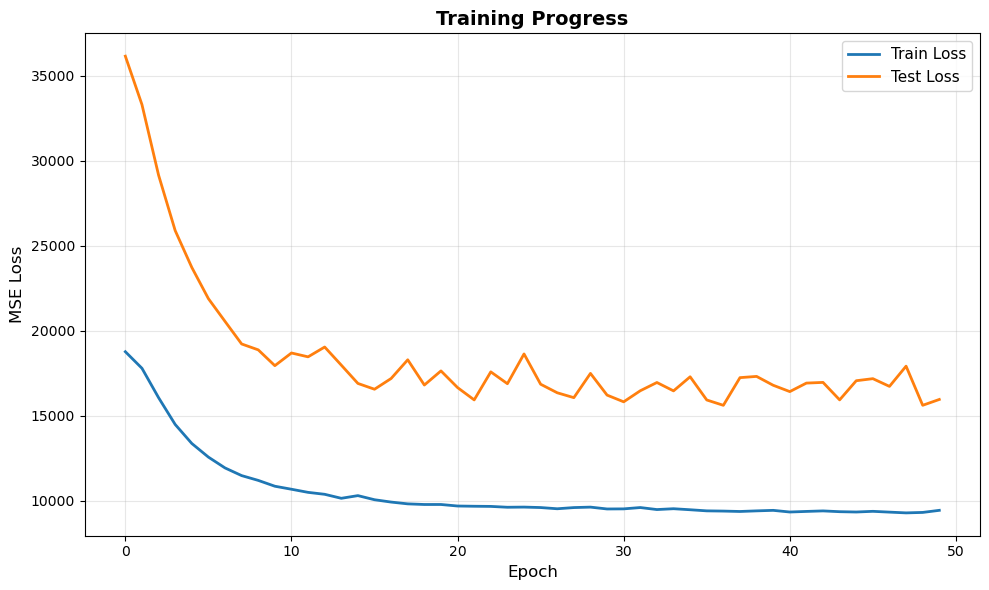

Final Train Loss: 9444.4550
Final Test Loss: 15968.1691


In [ ]:
# Plot training curves
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(train_losses, label='Train Loss', linewidth=2)
ax.plot(test_losses, label='Test Loss', linewidth=2)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('MSE Loss', fontsize=12)
ax.set_title('Training Progress', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final Train Loss: {train_losses[-1]:.4f}")
print(f"Final Test Loss: {test_losses[-1]:.4f}")

In [ ]:
# Make predictions on test set
model.eval()
all_predictions = []
all_targets = []

with torch.no_grad():
    for dyn_seq, static, y, edge_index in test_loader:
        dyn_seq = dyn_seq.squeeze(0).to(DEVICE)
        static = static.squeeze(0).to(DEVICE)        # <- ADD .squeeze(0)
        y = y.squeeze(0).to(DEVICE)
        edge_index = edge_index.squeeze(0).to(DEVICE)  # <- ADD .squeeze(0)
        
        y_hat = model(dyn_seq, static, edge_index)
        
        all_predictions.append(y_hat.cpu().numpy())
        all_targets.append(y.cpu().numpy())

all_predictions = np.concatenate(all_predictions)
all_targets = np.concatenate(all_targets)

print(f"Predictions shape: {all_predictions.shape}")
print(f"Targets shape: {all_targets.shape}")

Predictions shape: (211660,)
Targets shape: (211660,)


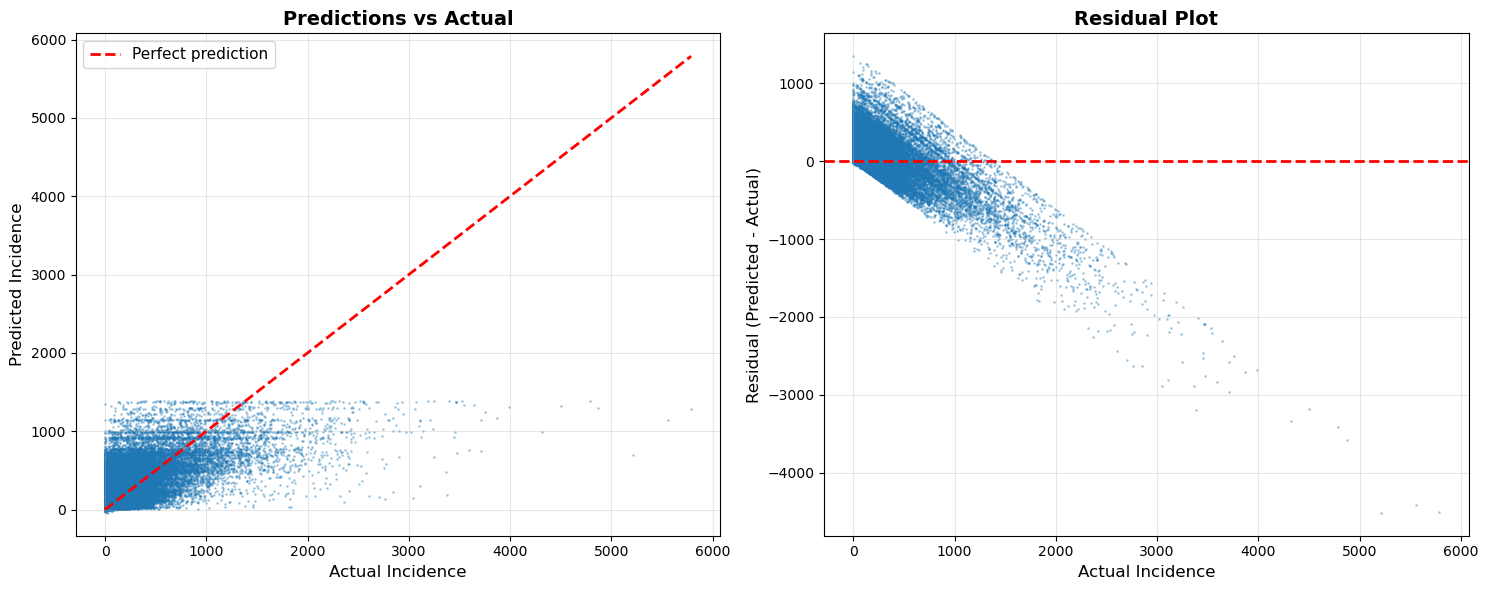

Mean Absolute Error: 44.6268
R² Score: 0.5447


In [ ]:
# Plot predictions vs actual
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot
axes[0].scatter(all_targets, all_predictions, alpha=0.3, s=1)
axes[0].plot([0, all_targets.max()], [0, all_targets.max()], 'r--', lw=2, label='Perfect prediction')
axes[0].set_xlabel('Actual Incidence', fontsize=12)
axes[0].set_ylabel('Predicted Incidence', fontsize=12)
axes[0].set_title('Predictions vs Actual', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Residual plot
residuals = all_predictions - all_targets
axes[1].scatter(all_targets, residuals, alpha=0.3, s=1)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Actual Incidence', fontsize=12)
axes[1].set_ylabel('Residual (Predicted - Actual)', fontsize=12)
axes[1].set_title('Residual Plot', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate metrics
from sklearn.metrics import mean_absolute_error, r2_score

mae = mean_absolute_error(all_targets, all_predictions)
r2 = r2_score(all_targets, all_predictions)

print(f"Mean Absolute Error: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

In [ ]:
# Calculate prediction metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Reshape predictions and targets per municipality for proper MASE/RMSSE calculation
# We need to reshape: (total_samples,) -> (num_timesteps, num_municipalities)
num_municipalities = train_ds.num_nodes
num_test_timesteps = len(test_ds)

# Reshape
predictions_reshaped = all_predictions.reshape(num_test_timesteps, num_municipalities)
targets_reshaped = all_targets.reshape(num_test_timesteps, num_municipalities)

print(f"Reshaped to: {predictions_reshaped.shape}")

# Get training data for scaling (naive baseline)
train_targets = []
with torch.no_grad():
    for dyn_seq, static, y, edge_index in train_loader:
        y = y.squeeze(0).cpu().numpy()
        train_targets.append(y)

train_targets = np.array(train_targets)  # [num_train_timesteps, num_municipalities]

# Calculate metrics
def calculate_mase(y_true, y_pred, y_train):
    """
    Mean Absolute Scaled Error
    Scale errors by the MAE of the naive forecast (seasonal naive with period=1)
    """
    # Naive forecast: use previous value
    naive_mae = np.mean(np.abs(np.diff(y_train, axis=0)))
    mae = np.mean(np.abs(y_true - y_pred))
    mase = mae / (naive_mae + 1e-10)  # avoid division by zero
    return mase

def calculate_rmsse(y_true, y_pred, y_train):
    """
    Root Mean Squared Scaled Error
    """
    # Naive forecast MSE
    naive_mse = np.mean(np.diff(y_train, axis=0) ** 2)
    mse = np.mean((y_true - y_pred) ** 2)
    rmsse = np.sqrt(mse) / (np.sqrt(naive_mse) + 1e-10)
    return rmsse

# Standard metrics
mae = mean_absolute_error(all_targets, all_predictions)
rmse = np.sqrt(mean_squared_error(all_targets, all_predictions))
r2 = r2_score(all_targets, all_predictions)

# MASE and RMSSE
mase = calculate_mase(targets_reshaped, predictions_reshaped, train_targets)
rmsse = calculate_rmsse(targets_reshaped, predictions_reshaped, train_targets)

# MAPE (Mean Absolute Percentage Error)
# Avoid division by zero
mask = all_targets > 0

print("\n" + "="*60)
print("PREDICTION METRICS")
print("="*60)
print(f"MAE (Mean Absolute Error):              {mae:.4f}")
print(f"RMSE (Root Mean Squared Error):         {rmse:.4f}")
print(f"MASE (Mean Absolute Scaled Error):      {mase:.4f}")
print(f"RMSSE (Root Mean Squared Scaled Error): {rmsse:.4f}")
print(f"R² Score:                                {r2:.4f}")
print("="*60)

# Interpretation guide
print("\nMetric Interpretation:")
print("- MASE < 1: Model beats naive baseline")
print("- MASE = 1: Model equals naive baseline")
print("- MASE > 1: Model worse than naive baseline")
print("\n- RMSSE: Similar to MASE but penalizes large errors more")
print("- R²: Proportion of variance explained (closer to 1 is better)")

Reshaped to: (38, 5570)

PREDICTION METRICS
MAE (Mean Absolute Error):              44.6268
RMSE (Root Mean Squared Error):         126.3652
MASE (Mean Absolute Scaled Error):      0.8905
RMSSE (Root Mean Squared Scaled Error): 0.6791
R² Score:                                0.5447

Metric Interpretation:
- MASE < 1: Model beats naive baseline
- MASE = 1: Model equals naive baseline
- MASE > 1: Model worse than naive baseline

- RMSSE: Similar to MASE but penalizes large errors more
- R²: Proportion of variance explained (closer to 1 is better)


In [ ]:
# Save the trained model
model_path = Path("../models/gnn_dengue.pt")
model_path.parent.mkdir(parents=True, exist_ok=True)

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'test_losses': test_losses,
}, model_path)

print(f"Model saved to {model_path}")

Model saved to ..\models\gnn_dengue.pt
